2025-01-23 12:59:48.024743: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 12:59:48.081015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 12:59:48.081081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 12:59:48.082482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 12:59:48.091907: I tensorflow/core/platform/cpu_feature_guar

Enhanced Grayscale Image - Width: 248, Height: 203
1/1 [==============================] - 1s 683ms/step


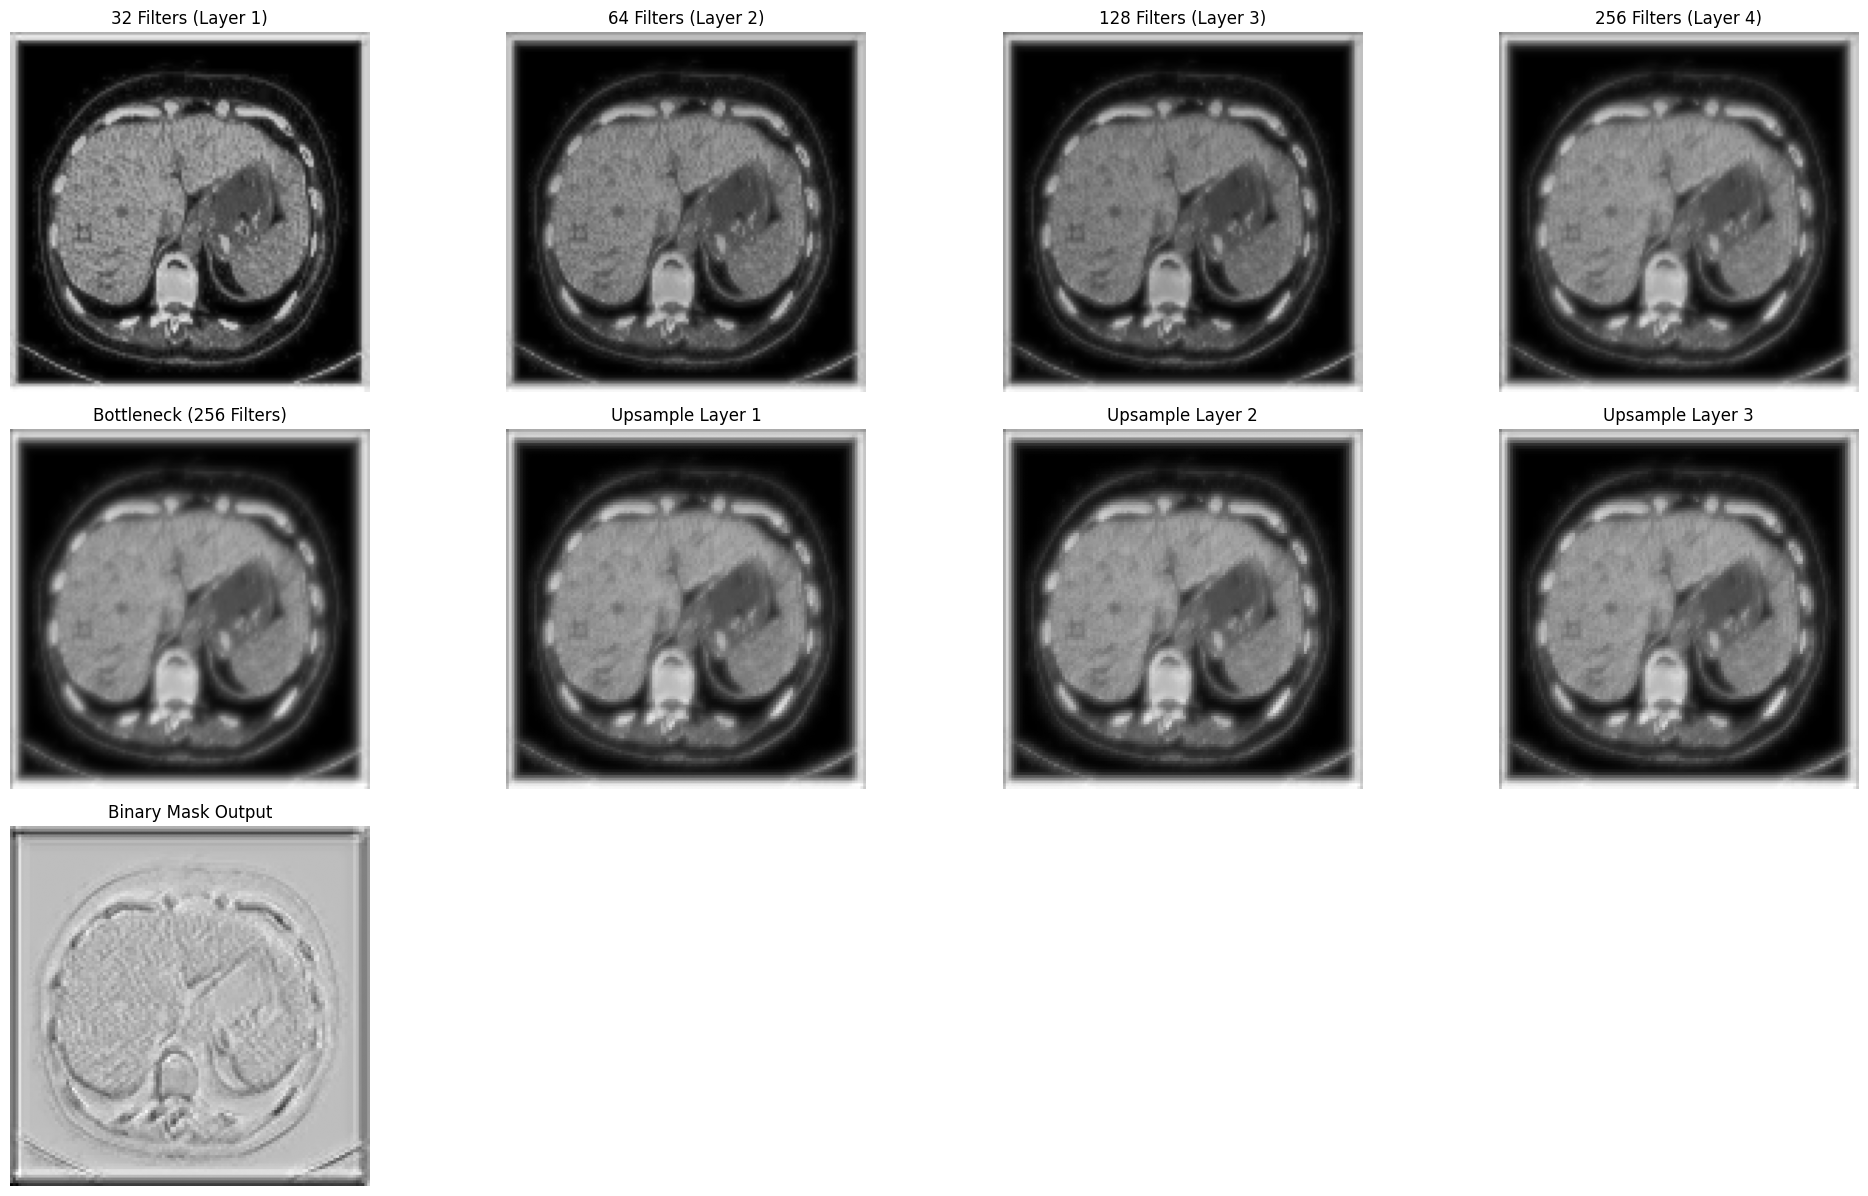

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Add, UpSampling2D
import cv2
import tensorflow as tf
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Clear GPU memory and set memory growth to avoid errors
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

# Set TensorFlow to use CPU only to avoid GPU memory errors
tf.config.set_visible_devices([], 'GPU')

# Load the grayscale image
img_path = '/home/icmr/Pictures/CT.jpeg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Enhance the image using histogram equalization
img_enhanced = cv2.equalizeHist(img)

# Check the enhanced image dimensions
height, width = img_enhanced.shape
print(f"Enhanced Grayscale Image - Width: {width}, Height: {height}")

# Resize the image to smaller size (optional step to reduce memory consumption)
resized_img = cv2.resize(img_enhanced, (128, 128))  # Resize to smaller dimensions
resized_height, resized_width = resized_img.shape

# Normalize the resized image (scale pixel values to range [0, 1])
resized_img_normalized = resized_img / 255.0

# Add an extra dimension to represent the batch size (needed for Keras)
# Since the image is grayscale, we only have one channel
img_batch = np.expand_dims(np.expand_dims(resized_img_normalized, axis=-1), axis=0)

# Define the input layer
input_layer = Input(shape=(resized_height, resized_width, 1))

# Residual Block definition with shortcut matching
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Apply 1x1 convolution to the shortcut to match the number of filters
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
    
    x = Add()([x, shortcut])  # Add the shortcut and the convolution output
    x = tf.keras.layers.ReLU()(x)
    return x

# Encoder: Downsampling (apply residual blocks)
conv_layer1 = residual_block(input_layer, 32)
conv_layer2 = residual_block(conv_layer1, 64)
conv_layer3 = residual_block(conv_layer2, 128)
conv_layer4 = residual_block(conv_layer3, 256)

# Bottleneck: Deepest layer with 256 filters
bottleneck = residual_block(conv_layer4, 256)

# Decoder: Upsampling (apply upsampling and residual blocks)
up_layer3 = UpSampling2D(size=(2, 2))(bottleneck)
up_layer2 = UpSampling2D(size=(2, 2))(up_layer3)
up_layer1 = UpSampling2D(size=(2, 2))(up_layer2)

# Final segmentation output layer with sigmoid activation (binary mask)
segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up_layer1)

# Create the model
model = Model(inputs=input_layer, outputs=segmentation_output)

# Define a new model to output intermediate layers
intermediate_model = Model(inputs=input_layer, outputs=[conv_layer1, conv_layer2, conv_layer3, conv_layer4, bottleneck, up_layer1, up_layer2, up_layer3, segmentation_output])

# Get the filtered outputs from the intermediate model (including the residual connections)
filtered_imgs = intermediate_model.predict(img_batch)

# Remove the batch dimension from each output
filtered_imgs = [filtered_img[0] for filtered_img in filtered_imgs]

# Display the downsampling, bottleneck, upsampling outputs, and the binary mask
plt.figure(figsize=(20, 20))

# Display each downsampling filter output
downsampling_titles = ['32 Filters (Layer 1)', '64 Filters (Layer 2)', '128 Filters (Layer 3)', '256 Filters (Layer 4)']
for i, filtered_img in enumerate(filtered_imgs[:4]):
    summed_filter_img = np.sum(filtered_img, axis=-1)  # Sum all feature maps
    plt.subplot(5, 4, i + 1)
    plt.imshow(summed_filter_img, cmap='gray')
    plt.title(downsampling_titles[i])
    plt.axis('off')

# Display bottleneck output with 256 filters
summed_bottleneck = np.sum(filtered_imgs[4], axis=-1)  # Sum all feature maps at bottleneck
plt.subplot(5, 4, 5)
plt.imshow(summed_bottleneck, cmap='gray')
plt.title('Bottleneck (256 Filters)')
plt.axis('off')

# Display each upsampling filter output
upsampling_titles = ['Upsample Layer 1', 'Upsample Layer 2', 'Upsample Layer 3']
for i, filtered_img in enumerate(filtered_imgs[5:8]):
    summed_filter_img = np.sum(filtered_img, axis=-1)  # Sum all feature maps
    plt.subplot(5, 4, i + 6)
    plt.imshow(summed_filter_img, cmap='gray')
    plt.title(upsampling_titles[i])
    plt.axis('off')

# Display binary mask output
binary_mask = filtered_imgs[8]  # Final binary mask output
plt.subplot(5, 4, 9)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask Output')
plt.axis('off')

plt.tight_layout()
plt.show()
